# Dependancies

In [6]:
! pip install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# GPU support for tensorflow

In [7]:
import tensorflow as tf

GPUs = tf.config.list_physical_devices("GPU")

if GPUs:
    print(len(GPUs),"GPU found...")
    for GPU in GPUs:
        tf.config.experimental.set_memory_growth(GPU,True)
        print(GPU)
else:
    print(GPUs)
    print("GPU not found")

1 GPU found...
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Constants

In [8]:
IMGS_PATH = "./DATA/images/"
LABEL_PATH= "./DATA/labels/"
RANDOM_STATE = 35
IMG_COUNT = 100

# Defined Functions

In [9]:
import time
import cv2
import os
import uuid
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import json_load
import numpy as np


# for capturing imgs with opencv 
def capture_images(img_count):
    print("collecting images...")
    cam = cv2.VideoCapture(0)
    try:
        for i in range(img_count):
            unique_id = str(uuid.uuid1())
            img_path = os.path.join(IMGS_PATH,unique_id+".jpg")
            captured,img = cam.read()
            if not captured:
                print("Failed to capture image"+str(i))
            if not img.any():
                print("Image {i} is empty.".format(str(i)))
            cv2.imwrite(img_path,img)
            cv2.imshow("Capturing images press (q) to terminate...",img)
            cv2.setWindowProperty("Capturing images press (q) to terminate...",cv2.WND_PROP_TOPMOST,1)
            time.sleep(0.5)

            key = cv2.waitKey(1) & 0xFF 

            if key == ord('q'):
                break
        cam.release()
        cv2.destroyAllWindows()

    except Exception as e:
        cam.release()
        cv2.destroyAllWindows()
        print(f"Error:{str(e)}")

def imgs_from_itr(itr):
    batch = itr.next()
    fig,ax = plt.subplots(ncols=4,figsize=(20,20))
    for idx,img in enumerate(batch):
        ax[idx].imshow(img) 
    plt.show()

def albumentorCoord_from_json(label,img_shape_list):
    # extracting json from path
    label = json_load(os.path.join(LABEL_PATH,label))

    coord_metrix = label["shapes"][0]["points"]
    coord_vector = [0,0,0000.1,0000.1]
    idx = 0 
    
    #converting coordinates which are in the form of metrix to vector
    for i in coord_metrix:
        for j in i:
            coord_vector[idx] = j
            idx+=1  
    #Converting v_coordinates in the format required by the abumentor expresses as the ratio bitween the coordinates to their respective height and weidth
    coordinates = np.divide(coord_vector,img_shape_list)
    return coordinates
    
def load_imgs(path):
    byte_img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(byte_img)
    return img

def create_Dataframe(imgs,labels):
    dataframe = pd.Dataframe()
    dataframe["images"]=imgs
    dataframe["labels"]=labels
    return dataframe

# Image Capture

In [10]:
#capture_images(IMG_COUNT)

# Handeling images with missing labels

Paths of imgs with missing labels...
ba01c5c4-b796-11ee-8c9c-00e02d94b4fb.jpg
ba557db2-b796-11ee-ba9f-00e02d94b4fb.jpg
baa9066c-b796-11ee-9c52-00e02d94b4fb.jpg
bafa7d3b-b796-11ee-a536-00e02d94b4fb.jpg
bb4e3b10-b796-11ee-9780-00e02d94b4fb.jpg
d71f0049-b796-11ee-8b83-00e02d94b4fb.jpg
d7724eaf-b796-11ee-b8eb-00e02d94b4fb.jpg
f8fdeb8c-b796-11ee-9e32-00e02d94b4fb.jpg
f94f450d-b796-11ee-a7be-00e02d94b4fb.jpg
fdc79a9f-b796-11ee-a8a5-00e02d94b4fb.jpg
fe1b1a93-b796-11ee-bf3f-00e02d94b4fb.jpg


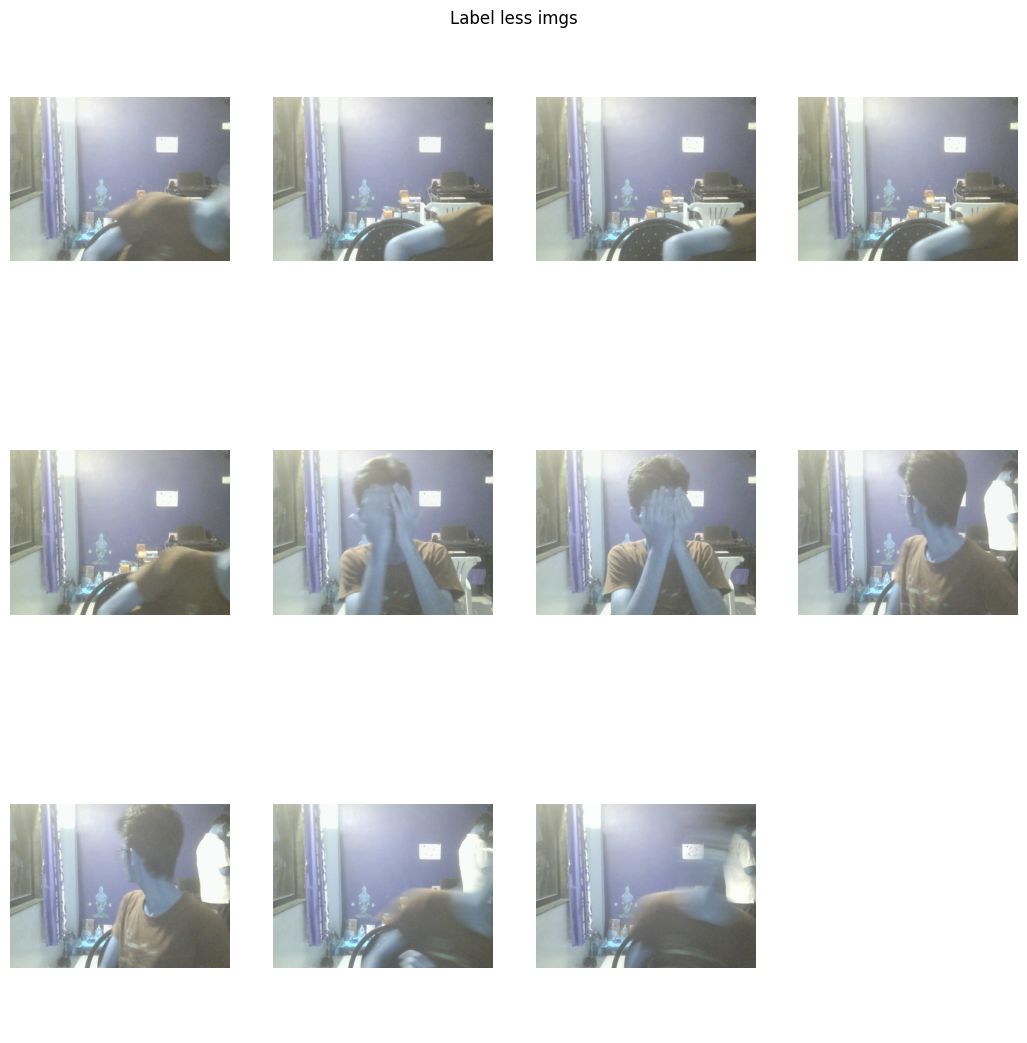

In [11]:
from matplotlib.font_manager import json_load
import pandas as pd
import json


i = 1
imgs= os.listdir(IMGS_PATH)
labels= os.listdir(LABEL_PATH)

plt.figure(figsize=(13,13))
plt.title("Label less imgs")
plt.axis("off")
print("Paths of imgs with missing labels...")

#if the imgs does not have a label NA will be inserted instead
for idx,img_path in enumerate(imgs):
    img_name = img_path.split(".")[0] 
    label = LABEL_PATH+img_name+".json"
    
    if not os.path.exists(label):
        img = cv2.imread(os.path.join(IMGS_PATH,img_path))
        plt.subplot(3,4,i)
        plt.imshow(img)
        plt.axis("off")
        i+=1
        print(img_path)
        labels.insert(idx,"NA")
plt.show()

# loading and displaying dumped images

In [12]:
dataframe = pd.DataFrame()
dataframe["images"] = imgs
dataframe["labels"] = labels
dataframe.head()

,images,labels
0,b43d6bd5-b796-11ee-8de8-00e02d94b4fb.jpg,b43d6bd5-b796-11ee-8de8-00e02d94b4fb.json
1,b4e26302-b796-11ee-9a48-00e02d94b4fb.jpg,b4e26302-b796-11ee-9a48-00e02d94b4fb.json
2,b5358450-b796-11ee-a75d-00e02d94b4fb.jpg,b5358450-b796-11ee-a75d-00e02d94b4fb.json
3,b586ac8a-b796-11ee-839e-00e02d94b4fb.jpg,b586ac8a-b796-11ee-839e-00e02d94b4fb.json
4,b5d8fd05-b796-11ee-9567-00e02d94b4fb.jpg,b5d8fd05-b796-11ee-9567-00e02d94b4fb.json


In [13]:
data = tf.data.Dataset.list_files("./DATA/images/*jpg")
dataset = data.map(load_imgs).batch(4)
data_itr = dataset.as_numpy_iterator()

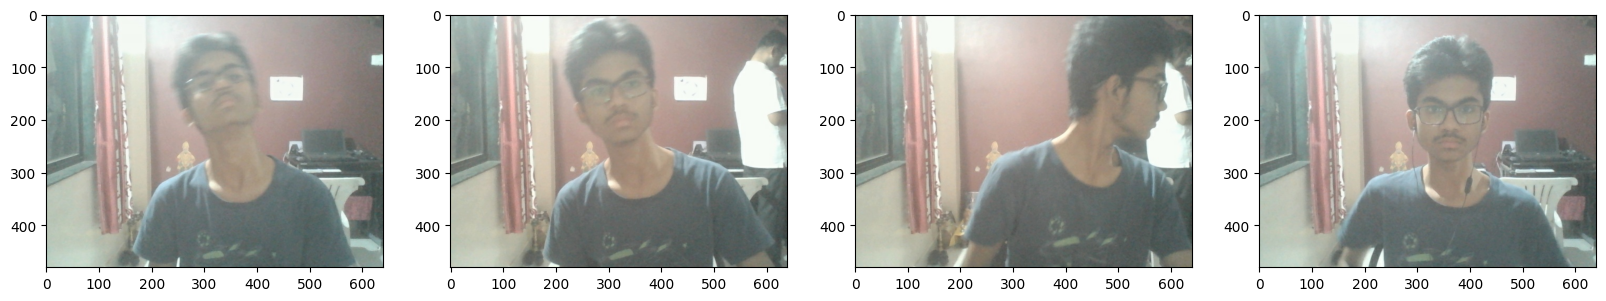

In [14]:
imgs_from_itr(data_itr)

# creating Albumentation to increase variation in data

In [15]:
import albumentations as alb

albumentor = alb.Compose([ 
    alb.RandomCrop(width=480,height=480),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RGBShift(p=0.2),
    alb.RandomGamma(p=0.2)],
    bbox_params=(
        alb.BboxParams(format="albumentations",
                       label_fields=["class_labels"])
    )
)

# testing the albumetor

In [16]:
# Test img info
img_name = dataframe["images"][15]
img = cv2.imread(os.path.join(IMGS_PATH,img_name))
print(img_name)
print(img.shape)

b95b2e1f-b796-11ee-99c2-00e02d94b4fb.jpg
(480, 640, 3)


In [17]:
# process to get bindingbox coordinates
label =  dataframe["labels"][15]
imgShapeList = [640,480,640,480]
bbox_coordinates = albumentorCoord_from_json(label,imgShapeList)
print("bbox_coordinates:",bbox_coordinates)

bbox_coordinates: [0.48766447 0.08442982 0.83470395 0.68640351]


In [18]:
# visualizing the format albumented data 
abumented = albumentor(image=img, bboxes=[bbox_coordinates],class_labels=["face"])
print(abumented)

{'image': array([[[205, 186, 183],
        [205, 187, 182],
        [202, 186, 181],
        ...,
        [120, 109, 108],
        [118, 104, 103],
        [117, 103, 102]],

       [[205, 187, 182],
        [205, 187, 182],
        [202, 187, 180],
        ...,
        [121, 110, 109],
        [120, 107, 106],
        [119, 106, 104]],

       [[205, 187, 181],
        [204, 186, 180],
        [203, 188, 181],
        ...,
        [123, 109, 110],
        [121, 107, 108],
        [121, 107, 108]],

       ...,

       [[175, 173, 161],
        [174, 173, 159],
        [173, 173, 156],
        ...,
        [109,  94,  71],
        [111,  96,  73],
        [115, 101,  76]],

       [[175, 174, 160],
        [175, 174, 160],
        [178, 174, 158],
        ...,
        [109,  94,  73],
        [112,  97,  76],
        [116, 101,  78]],

       [[174, 173, 159],
        [175, 175, 158],
        [176, 173, 157],
        ...,
        [108,  93,  72],
        [113,  98,  77],
        [118, 

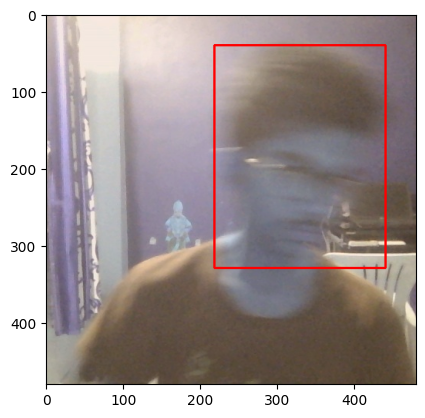

In [19]:
#visualizing albumented images
import numpy as np
cv2.rectangle(abumented["image"],
              tuple(np.multiply(abumented["bboxes"][0][:2],[480,480]).astype(int)),
              tuple(np.multiply(abumented["bboxes"][0][2:],[480,480]).astype(int)),
              (255,0,0),
              2
              )
plt.imshow(abumented["image"])

# Defined functions for phase 2

In [20]:
from turtle import end_fill
from sympy import false
import shutil

"""Generates augmented image frames and labels by applying Albumentations.

For each row in the input dataframe, loads the image and label data, extracts 
the face bounding box coordinates, normalizes them, and applies Albumentations 
to generate augmented examples. 

Args:
    dataframe: Input dataframe containing image paths and labels.

Returns:
    N_dataframe: New dataframe containing augmented image data and labels.
"""
def albument_frame(dataframe):
    imgs_list = []
    label_list = []
    coordinates = [0,0,0,0]

    for row in dataframe.itertuples():
        p_img = row.images
        p_label = row.labels
        img = cv2.imread(os.path.join(IMGS_PATH,p_img))
        
        if p_label != "NA":
            label = json_load(os.path.join(LABEL_PATH,p_label))
            points = label["shapes"][0]["points"]
            idx = 0 
            for i in points:
                for j in i:
                    coordinates[idx] = j
                    idx+=1  
            coordinates = np.divide(coordinates,[640,480,640,480])
            print(coordinates)
            
        for i in range(50):
            albumented = albumentor(image=img,bboxes=[coordinates],class_labels=["face"])
            agu_path = p_img.split(".")[0]+str(i)+".jpg"
            agu_img = albumented["image"]
            
            if len(albumented["bboxes"]) != 0 and p_label != "NA":
                agu_label = {"image":agu_path,"bboxes":albumented["bboxes"][0],"class":[1]}
            else:
                agu_label = {"image":agu_path,"bboxes":[0,0,0,0],"class":[0]}

            imgs_list.append(agu_img)
            label_list.append(agu_label)

    return pd.DataFrame({"images":imgs_list,"labels":label_list})


    
def var_name(var):
    all_var = locals()
    for name,value in all_var.items():
        print(all_var)
        if value==var:
            return name
        
# def var_name(var):
#     all_var = locals()
#     print("All variables in local scope:", all_var)
#     for name, value in all_var.items():
#         if hasattr(value, 'equals') and value.equals(var):
#             print(name)
#             return name
#     return None
def extract_labels(path):
    with open(path.numpy(),'r',encoding="utf-8") as f:
        data = json.load(f)
    return data["class"],data["bboxes"]

def dump_partition(df,directory):
    df.reset_index(drop=True,inplace=True)
    destination_folder = os.path.join(os.getcwd(),directory)
    
    if os.path.exists(destination_folder):
        shutil.rmtree(destination_folder)
        
    for i in range(len(df)):
        for col in df.columns:
            feature_folder = os.path.join(destination_folder,col)
            if not os.path.exists(feature_folder):
                os.makedirs(feature_folder)     
            
            if col == "images":
                distination_path = os.path.join(feature_folder,str(i)+".jpg")
                cv2.imwrite(distination_path,df[col][i])
            
            else:   
                distination_path = os.path.join(os.getcwd(),directory,col,str(i)+".json")
                with open(distination_path,'w' ) as f:
                    json.dump(df[col][i],f)
                    
def P_load_imgs(path):
    imgs = tf.data.Dataset.list_files(path,shuffle=false)
    # load resize and normalize
    imgs = imgs.map(load_imgs).map(lambda x: tf.image.resize(x,(120,120))/255)
    return imgs
    

def P_load_labels(path):
    labels = tf.data.Dataset.list_files(path,shuffle=false)
    labels = labels.map(lambda x: tf.py_function(func=extract_labels,inp=[x],Tout=[tf.uint8,tf.float16]))
    return labels


# Applying albumetation to the entire dataframe

In [21]:
ab_data = albument_frame(dataframe)
print(ab_data.head())
print(len(ab_data))

[0.47203947 0.04714912 0.76726974 0.61074561]
[0.46381579 0.04385965 0.76644737 0.61074561]
[0.36677632 0.05811404 0.67434211 0.59429825]
[0.41529605 0.04934211 0.734375   0.63486842]
[0.62828947 0.09429825 0.94901316 0.65570175]
[0.75       0.18201754 0.9984375  0.71678062]
[0.55345395 0.06798246 0.90296053 0.66008772]
[0.45723684 0.04385965 0.76398026 0.60635965]
[0.421875   0.04495614 0.72286184 0.62828947]
[0.32894737 0.0625     0.63980263 0.62390351]
[0.23601974 0.07127193 0.57483553 0.63486842]
[0.03865132 0.17105263 0.39638158 0.72697368]
[0.00082237 0.26535088 0.30427632 0.75438596]
[0.         0.41447368 0.22615132 0.875     ]
[0.16447368 0.11732456 0.48766447 0.66776316]
[0.48766447 0.08442982 0.83470395 0.68640351]
[0.69901316 0.13377193 0.9984375  0.71938346]
[0.73026316 0.00219298 0.9984375  0.60331808]
[0.48355263 0.01315789 0.82565789 0.58114035]
[0.39802632 0.00109649 0.71299342 0.58333333]
[0.42351974 0.07236842 0.69736842 0.59429825]
[0.42023026 0.07236842 0.72532895 

# Creating train,test and val partitions for ab_data

In [22]:
from sklearn.model_selection import train_test_split

train,temp = train_test_split(ab_data,train_size=0.7)
valid,test = train_test_split(temp,test_size=0.33)

print(train.head())
print(len(train))

NameError: name 'train_test_split' is not defined

# Dumping each partition

In [ ]:
# dumping data to folders
dump_partition(train,"train")
dump_partition(valid,"valid")
dump_partition(test,"test")


# Loading images and labels from each partition

In [ ]:
# loading imgs from partition folders
train_imgs = P_load_imgs("./train/images/*jpg")
valid_imgs = P_load_imgs("./valid/images/*jpg")
test_imgs = P_load_imgs("./test/images/*jpg")

# loading labels from partition folders
train_labels = P_load_labels("./train/labels/*json")
valid_labels = P_load_labels("./valid/labels/*json")
test_labels = P_load_labels("./test/labels/*json")

# inspecting the data
print("train_imgs:",len(train_imgs))
print("valid_imgs:",len(valid_imgs))
print("test_imgs:",len(test_imgs))
print("train_labels:",len(train_labels))
print("valid_labels:",len(valid_labels))
print("test_labels:",len(test_labels))


train_imgs: 3500
valid_imgs: 1005
test_imgs: 495
train_labels: 3500
valid_labels: 1005
test_labels: 495


In [ ]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.4392, 0.1437, 0.745 , 0.557 ], dtype=float16))

In [ ]:
train_imgs.as_numpy_iterator().next()

array([[[0.6       , 0.78333336, 0.85882354],
        [0.60294116, 0.78333336, 0.85588235],
        [0.61470586, 0.7970588 , 0.8598039 ],
        ...,
        [0.5470588 , 0.5745098 , 0.61960787],
        [0.54313725, 0.5647059 , 0.6019608 ],
        [0.5147059 , 0.5411765 , 0.5686275 ]],

       [[0.59607846, 0.7627451 , 0.8303922 ],
        [0.60882354, 0.77156866, 0.84117645],
        [0.6068627 , 0.7735294 , 0.8362745 ],
        ...,
        [0.53431374, 0.57843137, 0.6068627 ],
        [0.51960784, 0.5627451 , 0.57843137],
        [0.5254902 , 0.57058823, 0.5882353 ]],

       [[0.5852941 , 0.7637255 , 0.827451  ],
        [0.60294116, 0.77156866, 0.8382353 ],
        [0.59313726, 0.7705882 , 0.83431375],
        ...,
        [0.53431374, 0.56666666, 0.60784316],
        [0.53137255, 0.5647059 , 0.6039216 ],
        [0.52254903, 0.5617647 , 0.6019608 ]],

       ...,

       [[0.73137254, 0.8490196 , 0.845098  ],
        [0.7382353 , 0.8539216 , 0.84607846],
        [0.72843134, 0

# Combining labels and features.

In [ ]:
def combine_data(features,labels):
    data = tf.data.Dataset.zip((features,labels))
    data = data.shuffle(buffer_size=1000).batch(8).prefetch(8)
    return data

train = combine_data(train_imgs,train_labels)
valid = combine_data(valid_imgs,valid_labels)
test = combine_data(test_imgs,test_labels)


In [24]:
# inspection 
train.as_numpy_iterator().next()[1]


NameError: name 'train' is not defined

# visualization of train samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


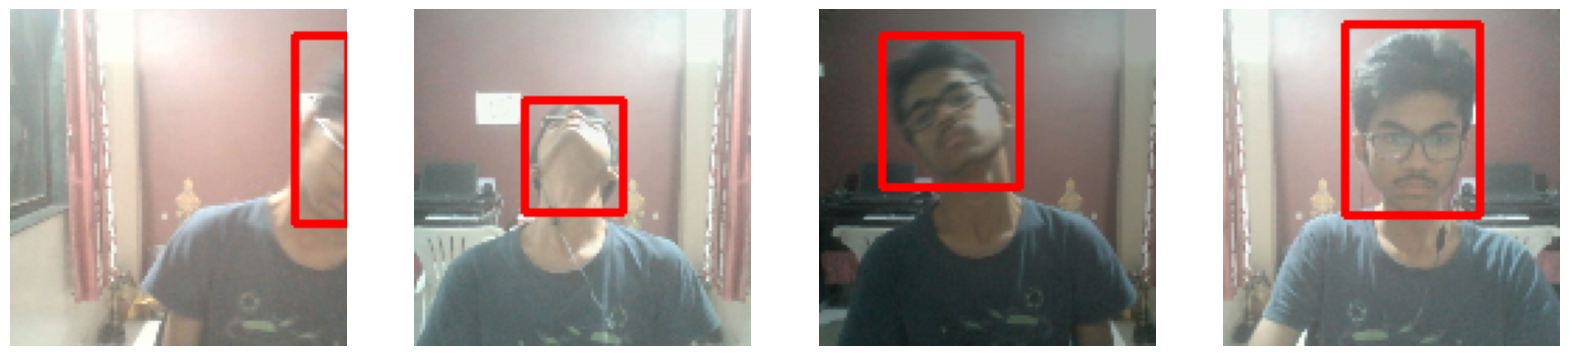

In [ ]:
samples = train.as_numpy_iterator().next()
fig, ax = plt.subplots(ncols=4,figsize=(20,20))


for idx in range(4): 
    sample_image = samples[0][idx].copy()
    sample_coords = samples[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)
    ax[idx].axis("off")
    
plt.show()
  


# Creating CNN from VGG16 base architecture

In [ ]:
from keras.models import Model
from keras.layers import Input,Conv2D,Dense,GlobalMaxPooling2D
from keras.applications import VGG16

In [ ]:
vgg16 = VGG16(include_top=False)
vgg16.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
def build_model():
    input_layer = Input(shape=(120,120,3))
    # callsification head
    vgg16_layers = VGG16(include_top=False)(input_layer) 
    
    mp1 = GlobalMaxPooling2D()(vgg16_layers)
    C_layer = Dense(2048,activation="relu")(mp1)
    _class  = Dense(1,activation="sigmoid")(C_layer)

    # regression head
    mp2 = GlobalMaxPooling2D()(vgg16_layers)
    R_layer = Dense(2048,activation="relu")(mp2)
    _bbox = Dense(4,activation="sigmoid")(R_layer)
    
    model = Model(inputs=input_layer,outputs=[_class,_bbox])
    return model



In [ ]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

 # testing model 

In [ ]:
x,y = train.as_numpy_iterator().next()
_Class,_Coord = model.predict(x)
print(_Class,_Coord)

1/1 [==============================] - 46s 46s/step
[[0.5363546 ]
 [0.58684844]
 [0.606499  ]
 [0.53232145]
 [0.53967845]
 [0.5760503 ]
 [0.54130465]
 [0.56751657]] [[0.5054251  0.3065405  0.45070916 0.30625248]
 [0.48512876 0.32509732 0.59282666 0.31309995]
 [0.54145503 0.37556332 0.48183963 0.30113378]
 [0.52493846 0.36183068 0.45039013 0.43634987]
 [0.50297725 0.34789422 0.47431585 0.41232774]
 [0.49736455 0.40829283 0.49019277 0.3384481 ]
 [0.54568386 0.3469422  0.47118932 0.3192606 ]
 [0.5543822  0.32747874 0.45175236 0.31259853]]


# Configuring Optimizers and learning rate decay


In [ ]:
batchs_per_epoch = len(train)
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001,decay_steps=batchs_per_epoch,decay_rate=0.75)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_decay)


# Defining the loss functions


In [ ]:
def localization_loss(y_true,y_pred):
    dif_position = tf.reduce_sum(tf.square(y_true[:,:2]-y_pred[:,:2]))
    
    true_w = y_true[:,3] - y_true[:,1]
    true_h = y_true[:,2] - y_true[:,0]
    
    pred_w = y_pred[:,3] - y_pred[:,1]
    pred_h = y_pred[:,2] - y_pred[:,0]
    
    dif_shape = tf.reduce_sum(tf.square(true_w - pred_w) + tf.square(true_h - pred_h))
    
    return dif_shape+dif_position

In [ ]:
classification_loss = tf.losses.BinaryCrossentropy()
regression_loss = localization_loss

In [25]:
# testing loss functions
classification_loss(y[0],_Class)
regression_loss(y[1],_Coord)

NameError: name 'classification_loss' is not defined

# creating a custom subclass to handle the model

In [ ]:
class facetracker(Model):
    def __init__(self,Model,**kwargs):
        super().__init__(**kwargs)
        self.model = Model
    
    def compile(self,optimizer,callsification_loss,regression_loss,**kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer
        self.classification_loss = classification_loss
        self.regression_loss = regression_loss
    
    def train_step(self,batch,**kwargs):
        x,y = batch
        
        with tf.GradientTape() as tape:
            _Class,_Coord = self.model(x)
          
            batch_closs = self.classification_loss(y[0],_Class)
            batch_rloss = self.regression_loss(tf.cast(y[1],tf.float32),_Coord)

            total_loss = batch_rloss+0.5*batch_closs

        grad = tape.gradient(total_loss,self.model.trainable_variables)
        optimizer.apply_gradients(zip(grad,self.model.trainable_variables))
        
        return {"Classification_Loss":batch_closs,"Regression_Loss":batch_rloss,"Total_Loss":total_loss}
    
    def test_step(self,batch,**kwargs):
        x,y = batch
        
        _Class,_Coord = self.model(x)
        
        batch_closs = self.classification_loss(y[0],_Class)
        batch_rloss = self.regression_loss(tf.cast(y[1],tf.float32),_Coord)
        
        total_loss = batch_rloss+0.5*batch_closs
        
        return {"Classification_Loss":batch_closs,"Regression_Loss":batch_rloss,"Total_Loss":total_loss}
    
    def call(self,X,**kwargs):
        return self.model(X)

In [ ]:
facetracker = facetracker(model)
facetracker.compile(optimizer,classification_loss,regression_loss)

# Training facetracker model

In [27]:
# defining the log directory
logs = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [ ]:
hist = facetracker.fit(train,epochs=40,callbacks=[logs],validation_data=valid)

Epoch 1/40
438/438 [==============================] - 41s 78ms/step - Classification_Loss: 0.0417 - Regression_Loss: 0.1300 - Total_Loss: 0.1509 - val_Classification_Loss: 2.7419e-05 - val_Regression_Loss: 0.0044 - val_Total_Loss: 0.0044
Epoch 2/40
438/438 [==============================] - 20s 44ms/step - Classification_Loss: 0.0023 - Regression_Loss: 0.0132 - Total_Loss: 0.0144 - val_Classification_Loss: 1.0359e-05 - val_Regression_Loss: 0.0040 - val_Total_Loss: 0.0040
Epoch 3/40
438/438 [==============================] - 20s 44ms/step - Classification_Loss: 0.0011 - Regression_Loss: 0.0098 - Total_Loss: 0.0104 - val_Classification_Loss: 9.7211e-05 - val_Regression_Loss: 0.0023 - val_Total_Loss: 0.0024
Epoch 4/40
438/438 [==============================] - 20s 45ms/step - Classification_Loss: 8.7584e-04 - Regression_Loss: 0.0062 - Total_Loss: 0.0066 - val_Classification_Loss: 1.8120e-05 - val_Regression_Loss: 0.0013 - val_Total_Loss: 0.0013
Epoch 5/40
438/438 [========================

# Reviewing performance graphically

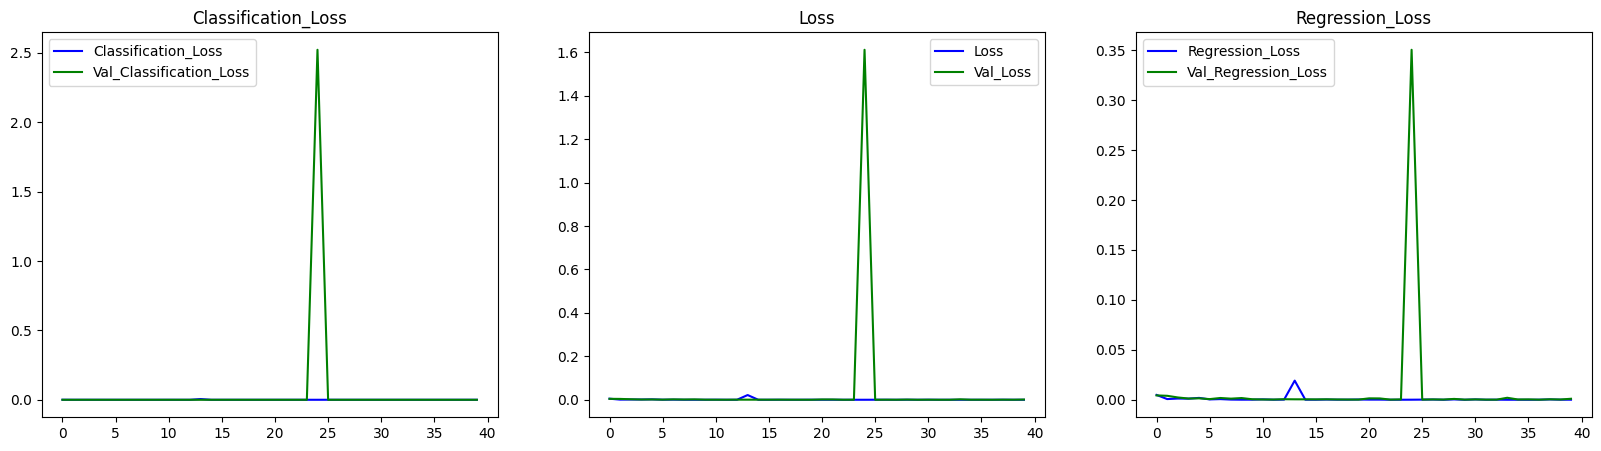

In [ ]:
fig,ax = plt.subplots(ncols=3,figsize=(20,5))

ax[0].plot(hist.history["Classification_Loss"],color="blue",label="Classification_Loss")
ax[0].plot(hist.history["val_Classification_Loss"],color="green",label="Val_Classification_Loss")
ax[0].title.set_text("Classification_Loss")
ax[0].legend()

ax[1].plot(hist.history["Total_Loss"],color="blue",label="Loss")
ax[1].plot(hist.history["val_Total_Loss"],color="green",label="Val_Loss")
ax[1].title.set_text("Loss")
ax[1].legend()

ax[2].plot(hist.history["Regression_Loss"],color="blue",label="Regression_Loss")
ax[2].plot(hist.history["val_Regression_Loss"],color="green",label="Val_Regression_Loss")
ax[2].title.set_text("Regression_Loss")
ax[2].legend()

# visualizing the predictions

1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


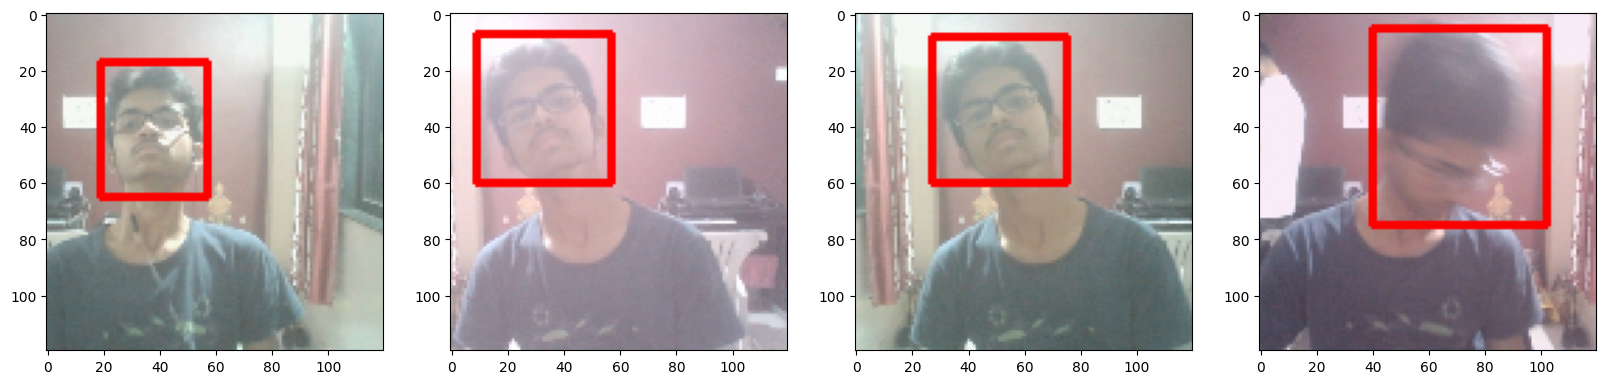

In [ ]:
imgs,label = test.as_numpy_iterator().next()
pred_class,pred_coord = facetracker.predict(imgs)

fig,ax = plt.subplots(ncols=4,figsize=(20,20))

for i in range(4):
    image =imgs[i].copy()
    coord = pred_coord[i]
    
    if pred_class[i] > 0.9 :
        cv2.rectangle(image,
                      tuple(np.multiply(coord[:2],[120,120]).astype(int)),
                      tuple(np.multiply(coord[2:],[120,120]).astype(int)),
                      (255,0,0),
                      2
                      )      
        
    ax[i].imshow(image)

# Dumping and loading Facetracker model

In [ ]:
model.save("model.h5")

NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker= load_model("model.h5")

# RealTime Face detection

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

cap = cv2.VideoCapture(0)

while cap.isOpened():
    print("hey")
    ret,frame = cap.read()
    if frame is None:
        print("Error: Image not loaded correctly.")
    # processing each frame
    frame = frame[50:500,50:500,:]
    x = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    x = tf.image.resize(x,(120,120)) 
    x = tf.expand_dims(x/255,0) 
    
    _class,b_coord = facetracker.predict(x)
    _coord = b_coord[0]
    
    p1 = np.multiply(_coord[:2],[450,450]).astype(int)
    p2 = np.multiply(_coord[2:],[450,450]).astype(int)
    
    if _class[0] > 0.9 :
        cv2.rectangle(frame,
                    tuple(p1),
                    tuple(p2),
                    (255,0,0),
                    2
        )
        cv2.rectangle(frame,
                    tuple(np.add(p1,[0,-30])),
                    tuple(np.add(p1,[80,0])),
                    (255,0,0),
                    -1
                    
        )
        cv2.putText(frame,
                    "Face",
                    tuple(np.add(p1,[0,-5])),
                    cv2.FONT_HERSHEY_COMPLEX,
                    1,
                    (255,255,255),
                    2
        )
   
    cv2.imshow("Face Detection",frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

hey
1/1 [==============================] - 0s 19ms/step
hey
1/1 [==============================] - 0s 18ms/step
hey
1/1 [==============================] - 0s 19ms/step
hey
1/1 [==============================] - 0s 18ms/step
hey
1/1 [==============================] - 0s 18ms/step
hey
1/1 [==============================] - 0s 18ms/step
hey
1/1 [==============================] - 0s 18ms/step
hey
1/1 [==============================] - 0s 19ms/step
hey
1/1 [==============================] - 0s 17ms/step
hey
1/1 [==============================] - 0s 18ms/step
hey
1/1 [==============================] - 0s 27ms/step
hey
1/1 [==============================] - 0s 17ms/step
hey
1/1 [==============================] - 0s 18ms/step
hey
1/1 [==============================] - 0s 18ms/step
hey
1/1 [==============================] - 0s 18ms/step
hey
1/1 [==============================] - 0s 18ms/step
hey
1/1 [==============================] - 0s 17ms/step
hey
1/1 [==============================] - 0s 18